<a href="https://colab.research.google.com/github/2018007956/HYU/blob/main/Deep_Learning/Assignment1/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='train', 
                    transform=transform,
                    download=True)
test_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='test',
                    transform=transform,
                    download=True)

In [ ]:
sample = test_dataset[0][0].numpy()
sample = np.transpose(sample,(1,2,0))

fig, ax = plt.subplots(1,1)
ax.set_title('data')
ax.set_axis_off()
ax.imshow(sample)
plt.show()

In [ ]:
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

## Encoder

In [ ]:
##### AutoEncoder 모델 코드 #####
class down_block(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=(3,3),stride=1,padding=1, bias=False):
        super(down_block, self).__init__()
        self.block1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,padding=padding, bias=bias)
        # self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.01) 
        self.dropout = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self,x):
        out = self.block1(x)
        # out = self.activation(self.bn1(out))
        out = self.activation(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        return out

class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder, self).__init__()
        self.encoder1 = down_block(in_channels=3, out_channels=16)
        self.encoder2 = down_block(in_channels=16, out_channels=32)
        self.encoder3 = down_block(in_channels=32, out_channels=64)

    def forward(self, input, test=False): # torch.Size([128, 3, 100, 100])
        out = self.encoder1(input) # torch.Size([128, 16, 50, 50])
        out = self.encoder2(out) # torch.Size([128, 32, 25, 25])
        out = self.encoder3(out) # ([128, 64, 12, 12])
        if test==False:
          out = out.view(batch_size, -1) 
        else:
          x = out.shape
          out = out.view(-1, x[1], x[2], x[3])   
        return out

In [ ]:
class up_block(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=4,stride=1,padding=14, bias=False): # padding=0: valid (no padding), padding=1: same (add 0 as padding)
        super(up_block, self).__init__()
        self.block1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,padding=padding, bias=bias)
        # self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self,x):
        out = self.activation(self.block1(x))
        out = self.dropout(out)
        return out

class Decoder(nn.Module):
    def __init__(self, ):
        super(Decoder, self).__init__()
        self.decoder1 = up_block(in_channels=64, out_channels=32, kernel_size=2, stride=1, padding=7)
        self.decoder2 = up_block(in_channels=32, out_channels=16, kernel_size=4, stride=1, padding=14)
        self.decoder3 = up_block(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=26)
        

    def forward(self, x):
        x = x.view(-1, 64, 12, 12)#32, 25, 25) 
        out = self.decoder1(x)
        out = self.decoder2(out)
        out = self.decoder3(out)
        return out


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input, test=False):
        z = self.encoder(input, test)
        x_hat = self.decoder(z)
        return z, x_hat

In [ ]:
##### AutoEncoder 학습 코드 #####
autoencoder = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00001)

Epoch : 1 / 30, cost: 0.3625912368297577


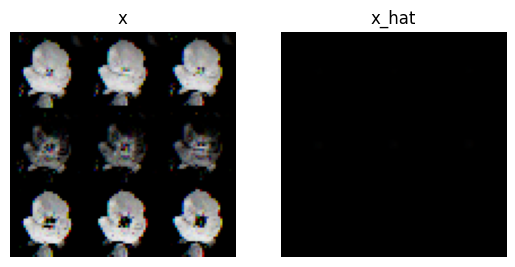

Epoch : 2 / 30, cost: 0.36083126068115234
Epoch : 3 / 30, cost: 0.3612023890018463
Epoch : 4 / 30, cost: 0.361616313457489
Epoch : 5 / 30, cost: 0.3613065481185913
Epoch : 6 / 30, cost: 0.36286360025405884
Epoch : 7 / 30, cost: 0.3574197292327881
Epoch : 8 / 30, cost: 0.36068499088287354
Epoch : 9 / 30, cost: 0.36232924461364746
Epoch : 10 / 30, cost: 0.3625926673412323
Epoch : 11 / 30, cost: 0.3616673946380615


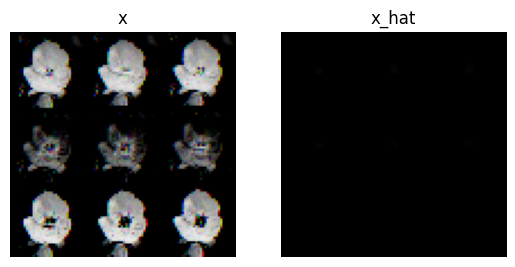

Epoch : 12 / 30, cost: 0.3588583767414093
Epoch : 13 / 30, cost: 0.36309298872947693
Epoch : 14 / 30, cost: 0.36314260959625244
Epoch : 15 / 30, cost: 0.3610471785068512
Epoch : 16 / 30, cost: 0.35894736647605896
Epoch : 17 / 30, cost: 0.3632015883922577
Epoch : 18 / 30, cost: 0.3604232370853424
Epoch : 19 / 30, cost: 0.363546222448349
Epoch : 20 / 30, cost: 0.3601185977458954
Epoch : 21 / 30, cost: 0.36022669076919556


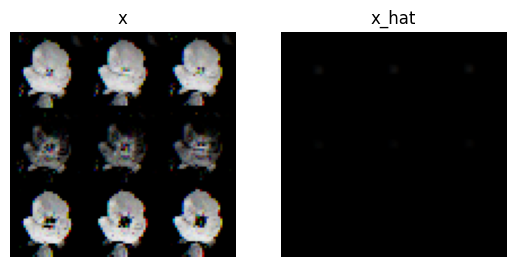

Epoch : 22 / 30, cost: 0.3602167069911957
Epoch : 23 / 30, cost: 0.36094653606414795
Epoch : 24 / 30, cost: 0.3636901378631592
Epoch : 25 / 30, cost: 0.35966458916664124
Epoch : 26 / 30, cost: 0.3575367331504822
Epoch : 27 / 30, cost: 0.3591682016849518
Epoch : 28 / 30, cost: 0.35738903284072876
Epoch : 29 / 30, cost: 0.3613565266132355
Epoch : 30 / 30, cost: 0.3591523766517639


In [ ]:
epochs =30
train_avg_costs = []
test_avg_costs = []

# EarlyStopping parameter
best_loss = 100

autoencoder.train()
for epoch in range(epochs):
  autoencoder.train()
  avg_cost = 0
  total_batch_num = len(train_dataloader)

  for b_x, b_y in train_dataloader:
    b_x = b_x.to(device)
    z, b_x_hat = autoencoder(b_x) # forward propagation
    loss = criterion(b_x_hat, b_x) # get cost

    avg_cost += loss/total_batch_num
    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update parameters
  train_avg_costs.append(avg_cost.detach().cpu())
  print('Epoch : {} / {}, cost: {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost=0
  test_total_batch = len(test_dataloader)
  autoencoder.eval()
  for b_x, b_y in test_dataloader:
    with torch.no_grad():
      b_x = b_x.to(device)
      z, logits = autoencoder(b_x)
      test_loss = criterion(logits, b_x) # get cost 
    test_avg_cost += test_loss / test_total_batch 

  test_avg_costs.append(test_avg_cost.detach().cpu())


  # observe differences
  sample = test_dataset[0][0].unsqueeze(0).to(device)
  if epoch % 10 ==0:
    autoencoder.eval()
    fig, ax = plt.subplots(1,2)
    with torch.no_grad():
      test_z, test_output = autoencoder(sample, test=True)
    ax[0].set_title('x')
    ax[1].set_title('x_hat')

    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[0].imshow(np.reshape(sample.detach().cpu(),(100,100,3)))
    ax[1].imshow(np.reshape(test_output.detach().cpu(),(100,100,3)))
    plt.show()


  # EarlyStopping
  if best_loss > test_avg_cost:
      model_state = copy.deepcopy(autoencoder.state_dict())
      best_loss = test_avg_cost
      stop_cnt = 0
  else:
      stop_cnt += 1
      print('StopCounting : {}'.format(stop_cnt))
      if stop_cnt == 10:
          print('Early Stop')
          break

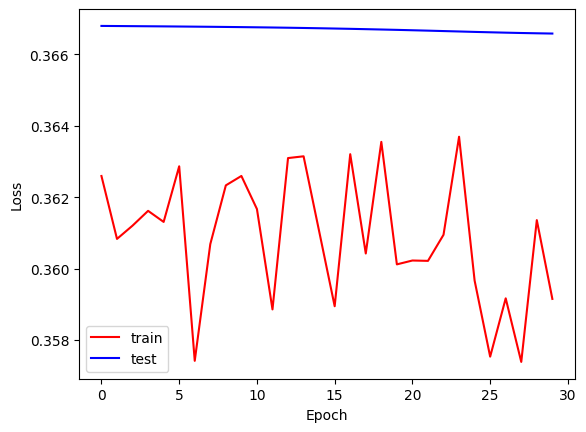

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# epoch = range(epochs)
epoch = range(len(train_avg_costs))
plt.plot(epoch, train_avg_costs, 'r-')
plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [ ]:
torch.save(autoencoder.state_dict(),'/content/drive/MyDrive/4rd_3l_drop__autoencoder_0.00001.pth')

## Load trained AE model

In [ ]:
# autoencoder = AutoEncoder().to(device)
# checkpoint = torch.load('/content/drive/MyDrive/4rd_3l_drop__autoencoder_0.00001.pth')
# autoencoder.load_state_dict(checkpoint)

<All keys matched successfully>

## Classifier

In [ ]:
##### Classifier 모델 코드 #####

class Classifier(nn.Module):
    def __init__(self, ):
      super(Classifier, self).__init__()
      self.linear1 = nn.Linear(64*12*12,1024)
      self.linear2 = nn.Linear(1024, 256)
      self.dropout = nn.Dropout(0.5)
      self.activation = nn.Sigmoid()
      self.cls = nn.Linear(256,102)

      self.bn1 = nn.BatchNorm1d(1024)
      self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
      # print(x.shape)
      z1 = self.linear1(x)
      z1 = self.bn1(z1) # activation 이전에 사용
      a1 = self.activation(z1)
      a1 = self.dropout(a1)

      z2 = self.linear2(a1)
      z2 = self.bn2(z2)
      a2 = self.activation(z2)
      a2 = self.dropout(a2)

      z = self.cls(a2)

      return z

In [ ]:
classifier = Classifier().to(device)

In [ ]:
cls_criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(
    [
      {"params": autoencoder.parameters(), "lr":0.001},
      {"params": classifier.parameters(), "lr":0.001},
    ]
)

In [ ]:
##### Classifier 학습 코드 #####
autoencoder.train()
classifier.train()
total_batch_num = len(train_dataloader)

epochs = 30
lmbd = 0.003
train_avg_costs = []
test_avg_costs = []
for epoch in range(epochs):
  avg_cost = 0

  for b_x, b_y in train_dataloader:
    b_x = b_x.to(device)
    z1, b_x_hat = autoencoder(b_x) # forward propagation
    logits = classifier(z1)
    loss = cls_criterion(logits, b_y.to(device)) # get cost

    # L2 Regularization
    reg = classifier.linear1.weight.pow(2.0).sum()
    reg += classifier.linear2.weight.pow(2.0).sum()
    # reg += classifier.linear3.weight.pow(2.0).sum()
    loss += lmbd*reg/len(b_x)/2.

    avg_cost += loss/total_batch_num

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update parameters
  train_avg_costs.append(avg_cost.detach().cpu())
  print('Epoch : {} / {}, cost: {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost=0
  test_total_batch = len(test_dataloader)
  autoencoder.eval()
  classifier.eval()
  for b_x, b_y in test_dataloader:
    with torch.no_grad():
      b_x = b_x.to(device)
      z, b_x_hat = autoencoder(b_x)
      logits = classifier(z)
      test_loss = cls_criterion(logits, b_y.to(device)) # get cost 
    test_avg_cost += test_loss / test_total_batch 

  test_avg_costs.append(test_avg_cost.detach().cpu())


Epoch : 1 / 30, cost: 4.71676778793335
Epoch : 2 / 30, cost: 4.621316432952881
Epoch : 3 / 30, cost: 4.562607288360596
Epoch : 4 / 30, cost: 4.449474334716797
Epoch : 5 / 30, cost: 4.316586017608643
Epoch : 6 / 30, cost: 4.171154022216797
Epoch : 7 / 30, cost: 4.0436201095581055
Epoch : 8 / 30, cost: 3.8993964195251465
Epoch : 9 / 30, cost: 3.7743661403656006
Epoch : 10 / 30, cost: 3.651822328567505
Epoch : 11 / 30, cost: 3.5190975666046143
Epoch : 12 / 30, cost: 3.401249408721924
Epoch : 13 / 30, cost: 3.2940850257873535
Epoch : 14 / 30, cost: 3.1708145141601562
Epoch : 15 / 30, cost: 3.029538869857788
Epoch : 16 / 30, cost: 2.9030981063842773
Epoch : 17 / 30, cost: 2.7603015899658203
Epoch : 18 / 30, cost: 2.6392412185668945
Epoch : 19 / 30, cost: 2.5381994247436523
Epoch : 20 / 30, cost: 2.3986399173736572
Epoch : 21 / 30, cost: 2.2981035709381104
Epoch : 22 / 30, cost: 2.179819345474243
Epoch : 23 / 30, cost: 2.044707775115967
Epoch : 24 / 30, cost: 1.8833729028701782
Epoch : 25 / 

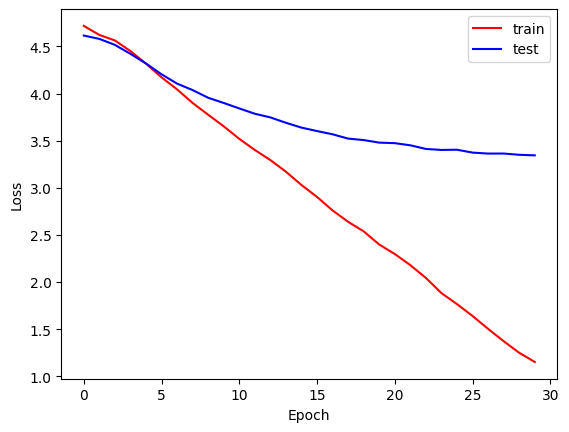

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epoch = range(epochs)
plt.plot(epoch, train_avg_costs, 'r-')
plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [ ]:
torch.save(classifier.state_dict(),'/content/drive/MyDrive/5rd_3L_classifier_0.001.pth')

In [ ]:
# 학습된 모델 가져오기
# classifier = Classifier().to(device)
# checkpoint = torch.load('/content/drive/MyDrive/classifier_0.001.pth')
# classifier.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
##### Classifier 정확도 측정 코드 #####
correct = 0
total = 0

autoencoder.eval()
classifier.eval()

for b_x, b_y in test_dataloader:
  with torch.no_grad():
    b_x = b_x.to(device)
    z1, b_x_hat = autoencoder(b_x)
    logits = classifier(z1)

  predicts = torch.argmax(logits, dim=1)

  total += len(b_y)
  correct += (predicts == b_y.to(device)).sum().item()

print(f"Accuracy of the network on test images: {100*correct/total} %")

Accuracy of the network on test images: 19.449869791666668 %
